In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm


import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import os
import glob
import numpy as np
import cv2

In [ ]:
base_path = "/content/drive/MyDrive/video_frame_color"

# 폴더 목록 가져오기
folder_list = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

# 각 폴더에서 이미지를 읽어 시퀀스로 저장
sequences = []
for folder in tqdm(folder_list, desc="Processing folders"):
    folder_path = os.path.join(base_path, folder)
    image_files = sorted(glob.glob(folder_path + "/*.jpg"))

    # 이미지를 읽고 numpy 배열로 변환
    images = [cv2.imread(file) for file in image_files]
    sequence = np.array(images)
    sequences.append(sequence)

# 시퀀스를 numpy 배열로 변환
dataset = np.array(sequences)

# 4차원으로 변환
dataset = np.expand_dims(dataset, axis=-1)

indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))


Processing folders:   5%|▌         | 30/552 [02:46<44:31,  5.12s/it]

Displaying frames for example 1.


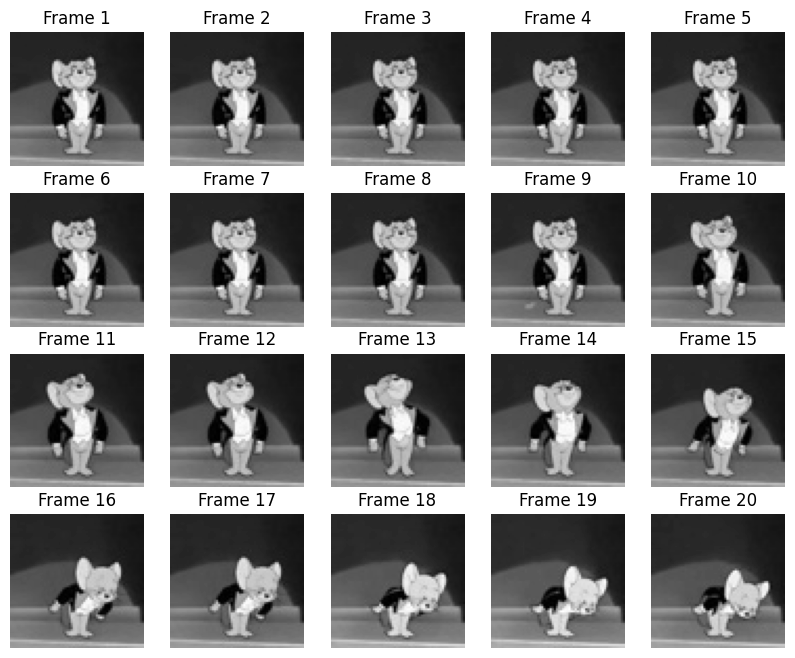

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=3, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)


# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.0001),
)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define some callbacks to improve training.
early_stopping = EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001, verbose=1
)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[reduce_lr, early_stopping],
)


Epoch 1/100
3/3 [==============================] - 12s 1s/step - loss: 0.6295 - val_loss: 0.6928 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 2s 707ms/step - loss: 0.5851 - val_loss: 0.6923 - lr: 1.0000e-04
Epoch 3/100
3/3 [==============================] - 2s 770ms/step - loss: 0.5731 - val_loss: 0.6918 - lr: 1.0000e-04
Epoch 4/100
3/3 [==============================] - 3s 945ms/step - loss: 0.5654 - val_loss: 0.6914 - lr: 1.0000e-04
Epoch 5/100
3/3 [==============================] - 2s 698ms/step - loss: 0.5601 - val_loss: 0.6908 - lr: 1.0000e-04
Epoch 6/100
3/3 [==============================] - 2s 689ms/step - loss: 0.5552 - val_loss: 0.6902 - lr: 1.0000e-04
Epoch 7/100
3/3 [==============================] - 2s 688ms/step - loss: 0.5516 - val_loss: 0.6895 - lr: 1.0000e-04
Epoch 8/100
3/3 [==============================] - 2s 713ms/step - loss: 0.5491 - val_loss: 0.6888 - lr: 1.0000e-04
Epoch 9/100
3/3 [==============================] - 2s 818ms/step - loss: 0

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 60ms/step
 Truth	Prediction
